In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization, Embedding, GRU, Dense, Conv1D, GlobalMaxPooling1D, Dropout, LayerNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle

# Load Dataset
df = pd.read_csv("final_dataset (1).csv")  
df = df.drop_duplicates()
df = df.sample(frac=1, random_state=42).reset_index(drop=True) 

X = df["Query"].astype(str).values  
y = df["Label"].values  

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# **Vectorizer Setup**
max_tokens = 10000
output_seq_len = 100

vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=output_seq_len,
    standardize='lower_and_strip_punctuation'
)

vectorizer.adapt(X_train)

# Transform text data into numerical form
X_train_vec = vectorizer(X_train).numpy()
X_test_vec = vectorizer(X_test).numpy()

# **Define Models**
models = {
    "GRU-64": keras.Sequential([
        Embedding(input_dim=max_tokens, output_dim=128, mask_zero=True),
        GRU(64, return_sequences=False),
        LayerNormalization(),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(len(label_encoder.classes_), activation="softmax")
    ]),
    
    "GRU-32": keras.Sequential([
        Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True),
        GRU(32, return_sequences=False, recurrent_dropout=0.1),
        Dense(32, activation="relu"),
        Dropout(0.3),
        Dense(len(label_encoder.classes_), activation="softmax")
    ]),
    
    "Conv1D": keras.Sequential([
        Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True),
        Conv1D(32, 3, activation="relu"),
        GlobalMaxPooling1D(),
        Dense(32, activation="relu"),
        Dropout(0.3),
        Dense(len(label_encoder.classes_), activation="softmax")
    ])
}

# **Train Models and Record Performance**
results = {}
for name, model in models.items():
    print(f"\n🔹 Training Model: {name}\n")
    
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    start_time = time.time()
    history = model.fit(X_train_vec, y_train, epochs=10, validation_data=(X_test_vec, y_test), batch_size=32, verbose=1)
    end_time = time.time()
    
    # Save results
    results[name] = {
        "history": history.history,
        "training_time": end_time - start_time,
        "model_size": model.count_params()
    }
    model.save(f"query_classifier_model_{name}.keras")




🔹 Training Model: GRU-64

Epoch 1/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.5493 - loss: 1.2125 - val_accuracy: 0.8526 - val_loss: 0.4275
Epoch 2/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.9138 - loss: 0.2823 - val_accuracy: 0.8526 - val_loss: 0.4816
Epoch 3/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.9566 - loss: 0.1447 - val_accuracy: 0.8521 - val_loss: 0.5047
Epoch 4/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.9780 - loss: 0.0911 - val_accuracy: 0.8553 - val_loss: 0.5199
Epoch 5/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9814 - loss: 0.0734 - val_accuracy: 0.8612 - val_loss: 0.5899
Epoch 6/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.9848 - loss: 0.0644 - val_accuracy: 0.8564 - val_loss: 0.6746
Epoch 7/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.9862 - loss: 0.0497 - val_accuracy: 0.8521 - val_loss: 0.7038
Epoch 8/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accurac

c:\Users\Tanushkumaaar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.4405 - loss: 1.5349 - val_accuracy: 0.8429 - val_loss: 0.5522
Epoch 2/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8566 - loss: 0.5081 - val_accuracy: 0.8790 - val_loss: 0.3744
Epoch 3/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9172 - loss: 0.2960 - val_accuracy: 0.8800 - val_loss: 0.3668
Epoch 4/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9459 - loss: 0.2057 - val_accuracy: 0.8752 - val_loss: 0.3772
Epoch 5/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9661 - loss: 0.1434 - val_accuracy: 0.8784 - val_loss: 0.3803
Epoch 6/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9739 - loss: 0.1234 - val_accuracy: 0.8768 - val_loss: 0.4042
Epoch 7/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9794 - loss: 0.0929 - val_accuracy: 0.8790 - val_loss: 0.4235
Epoch 8/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9849 - loss: 0.0716 - val_accuracy: 0.87

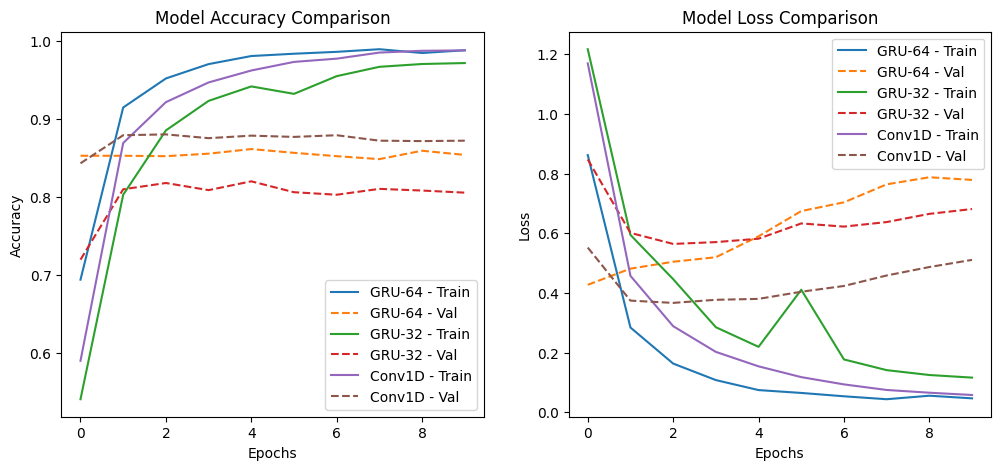


📊 Model Efficiency Summary:

🔹 GRU-64:
   - Training Time: 199.08 seconds
   - Model Size: 1321991 parameters
   - Final Training Accuracy: 0.9880
   - Final Validation Accuracy: 0.8537

🔹 GRU-32:
   - Training Time: 167.81 seconds
   - Model Size: 650695 parameters
   - Final Training Accuracy: 0.9716
   - Final Validation Accuracy: 0.8053

🔹 Conv1D:
   - Training Time: 41.80 seconds
   - Model Size: 647463 parameters
   - Final Training Accuracy: 0.9879
   - Final Validation Accuracy: 0.8720


In [10]:
# **Plot Performance Comparisons**
plt.figure(figsize=(12, 5))

# **Accuracy Plot**
plt.subplot(1, 2, 1)
for name, res in results.items():
    plt.plot(res["history"]["accuracy"], label=f"{name} - Train")
    plt.plot(res["history"]["val_accuracy"], linestyle="dashed", label=f"{name} - Val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.legend()

# **Loss Plot**
plt.subplot(1, 2, 2)
for name, res in results.items():
    plt.plot(res["history"]["loss"], label=f"{name} - Train")
    plt.plot(res["history"]["val_loss"], linestyle="dashed", label=f"{name} - Val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss Comparison")
plt.legend()

plt.show()

# **Print Efficiency Summary**
print("\n📊 Model Efficiency Summary:")
for name, res in results.items():
    print(f"\n🔹 {name}:")
    print(f"   - Training Time: {res['training_time']:.2f} seconds")
    print(f"   - Model Size: {res['model_size']} parameters")
    print(f"   - Final Training Accuracy: {res['history']['accuracy'][-1]:.4f}")
    print(f"   - Final Validation Accuracy: {res['history']['val_accuracy'][-1]:.4f}")


In [11]:
# **Save Model**
import os
os.replace('query_classifier_model_Conv1D.keras', 'query_classifier_model.keras')

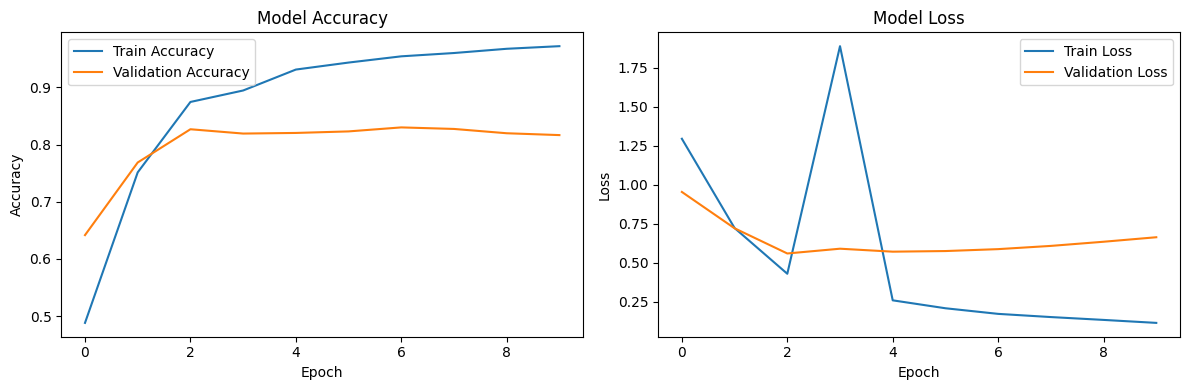

In [6]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
import tensorflow as tf
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder

reinforcement_data = []

# **Load Model**
model = tf.keras.models.load_model("query_classifier_model.keras")

# **Load Vectorizer Config**
with open("vectorizer_config.pkl", "rb") as f:
    config = pickle.load(f)

# **Recreate TextVectorization Layer**
vectorizer = tf.keras.layers.TextVectorization.from_config(config)

with open("vectorizer_vocab.pkl", "rb") as f:
    vocab = pickle.load(f)
vectorizer.set_vocabulary(vocab)

# **Load Label Encoder**
with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# **Function to Classify Queries**
def classify_query(queries):
    if isinstance(queries, str):  # Handle single query
        queries = [queries]

    # Ensure all inputs are strings
    queries = [q if isinstance(q, str) else "" for q in queries]

    # **Convert Text to Vectors**
    vectorized_queries = vectorizer(tf.constant(queries))

    # **Get Model Predictions**
    predictions = model.predict(vectorized_queries)  # Shape: (batch_size, num_classes)

    # **Find Predicted Class Indices**
    predicted_indices = np.argmax(predictions, axis=1)

    # **Convert Indices to Class Labels**
    predicted_labels = label_encoder.inverse_transform(predicted_indices)

    return {
        "classes": label_encoder.classes_.tolist(),
        "scores": predictions.tolist(),
        "predicted_labels": predicted_labels.tolist()
    }

# **Test Example**
example_queries = [
"""
Generate a photo into a ghilbil style
""",
]
print(classify_query(example_queries))


c:\Users\Tanushkumaaar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
{'classes': ['code generation', 'image classification', 'image generation', 'question answering', 'summarization', 'text classification', 'text generation'], 'scores': [[0.0006062525208108127, 0.10876133292913437, 0.8674536347389221, 0.0004751106898766011, 0.01949292980134487, 0.0012611058773472905, 0.0019495165906846523]], 'predicted_labels': ['image generation']}


In [17]:
import tensorflow as tf

# Load the Keras model
model = tf.keras.models.load_model("query_classifier_model.keras")

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# (Optional) Enable optimizations to reduce model size
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Save the TFLite model
with open("query_classifier_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite model conversion successful! 🚀")


c:\Users\Tanushkumaaar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


INFO:tensorflow:Assets written to: C:\Users\TANUSH~1\AppData\Local\Temp\tmpx5ltai6k\assets


INFO:tensorflow:Assets written to: C:\Users\TANUSH~1\AppData\Local\Temp\tmpx5ltai6k\assets


Saved artifact at 'C:\Users\TANUSH~1\AppData\Local\Temp\tmpx5ltai6k'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100), dtype=tf.float32, name='input_layer_6')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  1686986648144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1686986647376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1686986650448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1686986652560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1686986643920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1686986646992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1686986643152: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ TFLite model conversion successful! 🚀
